In [1]:
%%time
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

import pandas as pd
import wandb
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch


import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from matplotlib.patches import Rectangle

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

CPU times: user 2.61 s, sys: 2.26 s, total: 4.87 s
Wall time: 14.2 s


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Tables

In [3]:
# Table processing
def process_line(means, highlight, highlight_index, highlight_max, ignore_std):
    if highlight:
        if highlight_max:
            tops = set(means.groupby(highlight_index).idxmax())
        else:
            tops = set(means.groupby(highlight_index).idxmin())
    else:
        tops = set()

    def process_line(x):
        if ignore_std:
            if x.name in tops:
                return rf"\textbf{{{x['mean']:0.3f}}}"
            return rf"{x['mean']:0.3f}"
        if x.name in tops:
            return rf"\textbf{{{x['mean']:0.3f} $\pm$ {x['std']:0.3f}}}"
        return rf"{x['mean']:0.3f} $\pm$ {x['std']:0.3f}"

    return process_line


def mean_pm_std(
    data,
    index,
    columns,
    value,
    highlight=True,
    highlight_cols=True,
    highlight_max=True,
    ignore_std=False,
):
    assert len(data) > 0
    groupby = data.groupby([*index, *columns])
    means = groupby.mean()[value].rename("mean")
    stds = groupby.std()[value].rename("std")
    ddf = pd.concat([means, stds], axis=1).T
    highlight_index = columns if highlight_cols else index
    ddf = ddf.apply(
        process_line(means, highlight, highlight_index, highlight_max, ignore_std)
    )
    ddf = ddf.reset_index().pivot(index=index, columns=columns)
    ddf.columns = ddf.columns.droplevel(level=0)
    return ddf


def flatten_dict(d, parent_key="", sep="/"):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def prepare_data(data):
    flattened_data = [flatten_dict(item) for item in data]
    return pd.DataFrame(flattened_data)

In [4]:
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs(
    "openproblems-comp/DEM-2",
    filters={
        "$and": [
            {
                "tags": {
                    "$in": [
                        "lowtemp_eval",
                    ]
                },
                #'group': {'$in': ['5_vars']},
                # "config.data.n_particles": {"$eq": 22},
                #'config.model': {'$eq': model},
                #'config.lr': {'$lt': 1.01 * lr, '$gt': 0.99 * lr},
            }
        ]
    },
)

summary_list, config_list, name_list, tag_list = [], [], [], []
for run in runs:
    tag_list.append(run.tags)
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
    # .name is the human-readable name of the run.
    name_list.append(run.name)
df_summary = prepare_data(summary_list)
df_config = prepare_data(config_list)
tag_list = [str(t) for t in tag_list]
df = pd.concat(
    [
        pd.DataFrame(name_list, columns=["name"]),
        pd.DataFrame(tag_list, columns=["Tags"]),
        df_summary,
        df_config,
    ],
    axis=1,
)

In [5]:
import math


def filterer(x):
    if isinstance(x, float) and not math.isfinite(x):
        return False
    return "table" in list(x)


filtered_df = df[~((df["model/annealed_energy/temperature"].isin([0.7, 0.6])))][
    [
        # "tags",
        "test/temp_annealed/energy_w2",
        "test/temp_annealed/energy_w1",
        "test/temp_annealed/dist_w2",
        "model/annealed_energy/temperature",
        "model/resampling_interval",
        "model/scale_diffusion",
        "model/start_resampling_step",
        "model/resampling_strategy",
        "model/num_eval_samples",
    ]
]


# our w2 metric is w2^2
filtered_df["test/temp_annealed/energy_w2"] = np.sqrt(
    filtered_df["test/temp_annealed/energy_w2"]
)

In [6]:
renamed_df = filtered_df
# renamed_df = filtered_df.replace(
#     {
#         "src.models.components.tbg.egnn_dynamics_ad2_cat.EGNN_dynamics_AD2_cat": "EQ-CFM",
#         "src.models.components.dit.DIT3D": "DiT-CFM",
#     }
# ).rename(columns={"model/net/_target_": "Model", "data/n_particles": "n_particles"})

In [7]:
mylist = [
    "model/annealed_energy/temperature",
    "model/scale_diffusion",
    "model/resampling_interval",
    # "model/num_eval_samples",
    "model/resampling_strategy",
]

In [8]:
metrics = [
    "test/temp_annealed/energy_w2",
    "test/temp_annealed/energy_w1",
    "test/temp_annealed/dist_w2",
]
df_melt = renamed_df.melt(  # .dropna()
    value_vars=metrics,
    id_vars=mylist,
    var_name="Metric",
)


df_melt.loc[
    df_melt["model/resampling_interval"] == -1, "model/start_resampling_step"
] = 0
df_melt["model/resampling_strategy"] = df_melt["model/resampling_strategy"].fillna(
    "systematic"
)

# drop nan
df_melt = df_melt[df_melt["model/resampling_strategy"] == "systematic"]


df_melt = df_melt.drop(columns=["model/resampling_strategy"])

In [9]:
pd.set_option("display.max_rows", 500)

In [10]:
mylist = [
    "model/annealed_energy/temperature",
    "model/scale_diffusion",
    "model/resampling_interval",
]

results = mean_pm_std(
    df_melt, index=mylist, columns=["Metric"], value="value", highlight_max=False
)
# results.loc[results.index.get_level_values(0) == 1.0]
results

,,Metric,test/temp_annealed/dist_w2,test/temp_annealed/energy_w1,test/temp_annealed/energy_w2
model/annealed_energy/temperature,model/scale_diffusion,model/resampling_interval,,,
0.8,False,-1,\textbf{0.010 $\pm$ 0.000},9.887 $\pm$ 0.039,9.898 $\pm$ 0.040
0.9,False,-1,0.030 $\pm$ nan,14.732 $\pm$ nan,14.824 $\pm$ nan
1.0,False,-1,0.016 $\pm$ nan,\textbf{3.469 $\pm$ nan},169.045 $\pm$ nan
1.2,False,-1,0.021 $\pm$ nan,9.613 $\pm$ nan,9.684 $\pm$ nan
1.5,False,-1,0.074 $\pm$ 0.001,4.461 $\pm$ 0.024,\textbf{5.144 $\pm$ 0.042}


In [11]:
df_melt_temp1 = df_melt[
    (df_melt["model/annealed_energy/temperature"] == 0.8)
    # | (df_melt["model/annealed_energy/temperature"] == 0.8)
]

# df_melt_temp1.loc[:, "model/resampling_interval"] = df_melt_temp1[
#     "model/resampling_interval"
# ].map({-1: False, 1: True})

In [16]:
results_temp1

,,Metric,test/temp_annealed/dist_w2,test/temp_annealed/energy_w1,test/temp_annealed/energy_w2
model/annealed_energy/temperature,model/scale_diffusion,model/resampling_interval,,,
0.8,False,-1,0.010 $\pm$ 0.000,9.887 $\pm$ 0.039,9.898 $\pm$ 0.040


In [15]:
results_temp1 = mean_pm_std(
    df_melt_temp1, index=mylist, columns=["Metric"], value="value", highlight=False
)

print(
    results_temp1.to_latex(
        float_format="{:.3f}".format,
    )
)

\begin{tabular}{llllll}
\toprule
 &  & Metric & test/temp_annealed/dist_w2 & test/temp_annealed/energy_w1 & test/temp_annealed/energy_w2 \\
model/annealed_energy/temperature & model/scale_diffusion & model/resampling_interval &  &  &  \\
\midrule
0.800000 & False & -1 & 0.010 $\pm$ 0.000 & 9.887 $\pm$ 0.039 & 9.898 $\pm$ 0.040 \\
\cline{1-6} \cline{2-6}
\bottomrule
\end{tabular}



### Plotting

In [13]:
metric = "energy_w2"

# df_metric = df_melt[df_melt["Metric"] == f"test/temp_annealed/energy_{metric}"]
df_metric = df_melt[df_melt["Metric"] == f"test/temp_annealed/{metric}"]
grouped_energy_metric = (
    df_metric.groupby(
        [
            "model/annealed_energy/temperature",
            "model/scale_diffusion",
            "model/resampling_interval",
        ]
    )["value"]
    .agg(["mean", "std"])
    .reset_index()
)

grouped_energy_metric["model/resampling_interval"] = grouped_energy_metric[
    "model/resampling_interval"
].map({-1: False, 1: True})

In [18]:
grouped_energy_metric

,model/annealed_energy/temperature,model/scale_diffusion,model/resampling_interval,mean,std
0,0.8,False,False,9.898214,0.039665
1,0.9,False,False,14.823908,NaN
2,1.0,False,False,169.044974,NaN
3,1.2,False,False,9.683856,NaN
4,1.5,False,False,5.144279,0.041563


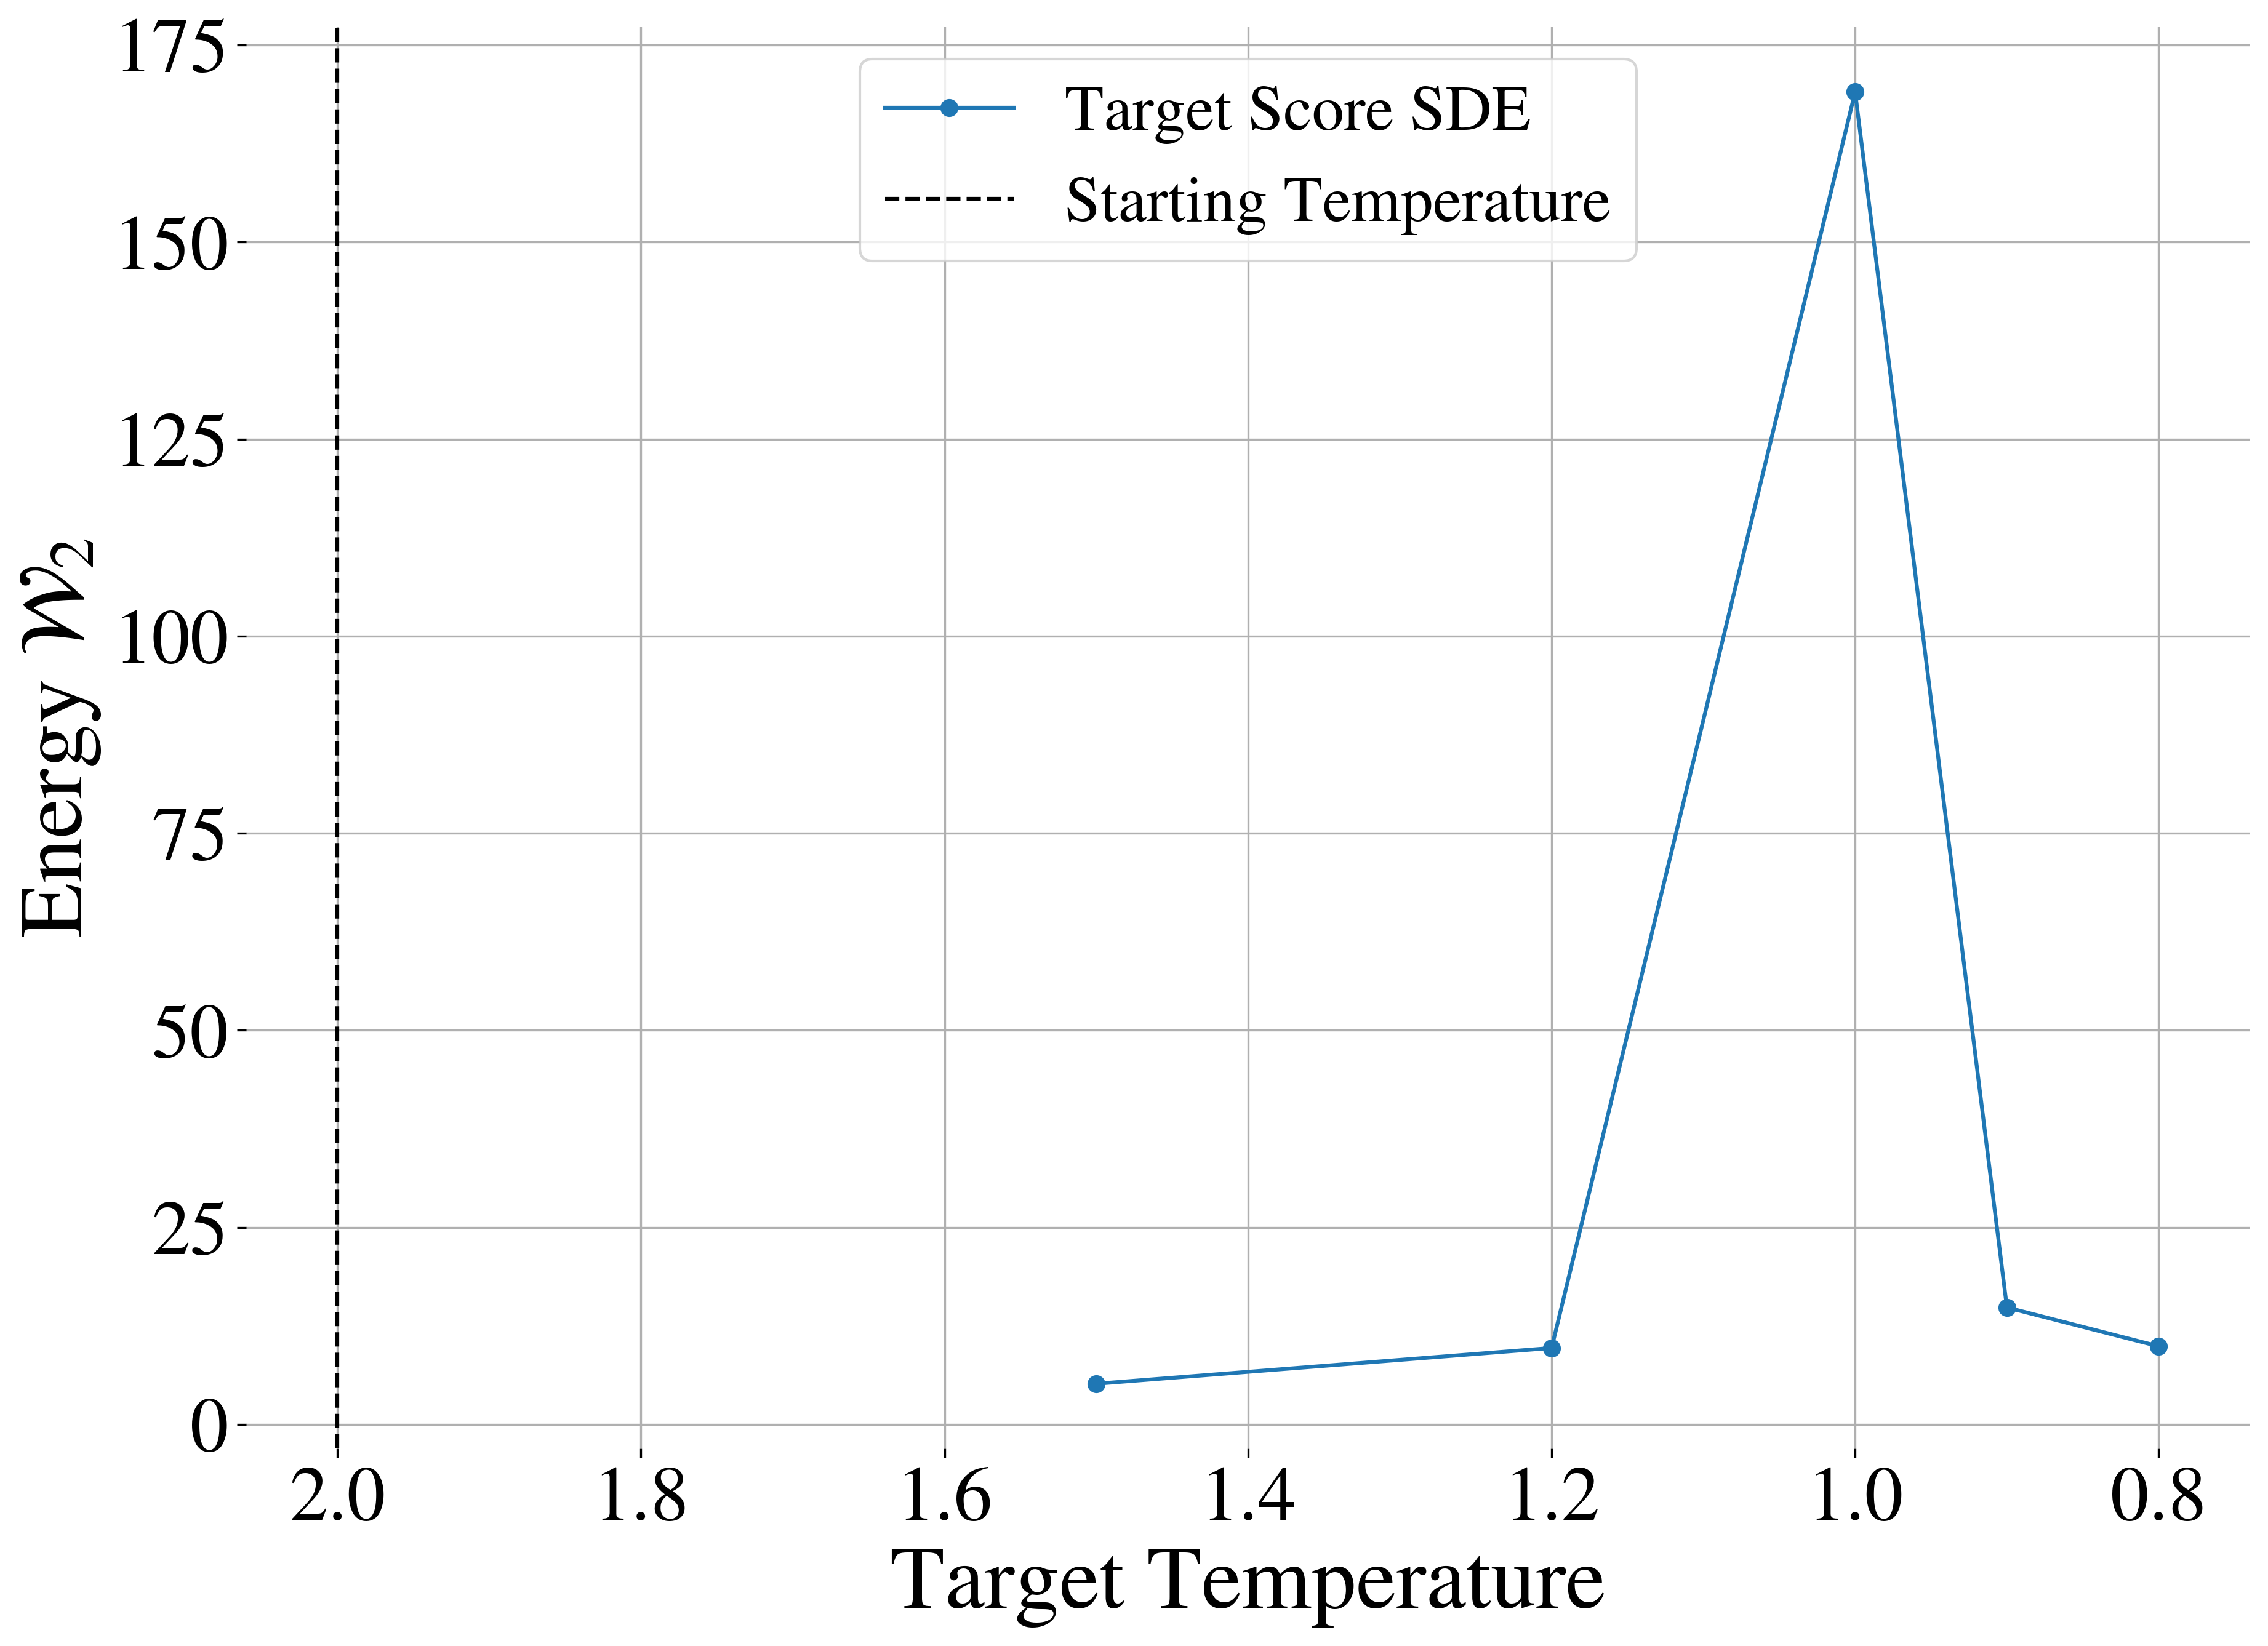

In [14]:
# Get unique values for resampling intervals and scale diffusion
resampling_intervals = sorted(
    grouped_energy_metric["model/resampling_interval"].unique()
)
scale_diffs = sorted(grouped_energy_metric["model/scale_diffusion"].unique())

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
fig.patch.set_facecolor("white")

# Iterate over combinations of resampling intervals and scale diffusion values
for ri in resampling_intervals:
    for sd in scale_diffs:
        subset = grouped_energy_metric[
            (grouped_energy_metric["model/resampling_interval"] == ri)
            & (grouped_energy_metric["model/scale_diffusion"] == sd)
        ]

        # plot mean and std as a shaded region

        if not sd:
            leg = "Target Score SDE"
        elif sd:
            leg = "Tempered Noise SDE"

        if ri:
            leg += f" + FKC"

        ax.plot(
            subset["model/annealed_energy/temperature"],
            subset["mean"],
            marker="o",
            linestyle="-",
            label=leg,
        )
        ax.fill_between(
            subset["model/annealed_energy/temperature"],
            subset["mean"] - subset["std"],
            subset["mean"] + subset["std"],
            alpha=0.3,
        )


# add vertical line at 2.0
ax.axvline(x=2.0, color="black", linestyle="--", label="Starting Temperature")

# Configure the plot
plt.xlabel("Target Temperature", fontsize=35)

if metric == "energy_w2":
    plt.ylabel(r"Energy $\mathcal{W}_2$", fontsize=35)
elif metric == "energy_w1":
    plt.ylabel(r"Energy $\mathcal{W}_1$", fontsize=35)
else:
    plt.ylabel(r"Interatomic Distances $\mathcal{W}_2$", fontsize=35)
plt.legend(fontsize=30)

# set x ticks size
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


# plt.title("Mean Energy W2 vs Temperature with Standard Deviation")
plt.grid(True)
plt.legend(fontsize=25)

ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

plt.gca().invert_xaxis()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.savefig(f"figures/LJ_{metric}_vs_temp.png", bbox_inches="tight")
plt.show()

### Plot Generated Samples

In [ ]:
annealed_samples_path = {}
dem_samples_path = {}

In [30]:
annealed_samples_path["tn", 0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_19-04-11/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/1/samples_temperature_0.8_10240.pt",
]

annealed_samples_path["ts", 0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/1/samples_temperature_0.8_10240.pt",
]

annealed_samples_path["tn+fkc", 0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-04/1/samples_temperature_0.8_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/1/samples_temperature_0.8_10240.pt",
]

annealed_samples_path["ts+fkc", 0.8] = [
    # for target score fkc
    # "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/1/samples_temperature_0.8_10240.pt",
    # "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/1/samples_temperature_0.8_10240.pt",
    # target fkc, 30, rare glass:
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-30_12-09-01/1/samples_temperature_0.8_10240.pt"
]

In [31]:
# annealed_samples_path[0.7] = [
#     "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/0/samples_temperature_0.7_10240.pt",
#     "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/0/samples_temperature_0.7_10240.pt",
#     "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_23-14-35/0/samples_temperature_0.7_10240.pt",
# ]

annealed_samples_path["ts", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/2/samples_temperature_0.9_10240.pt",
]
annealed_samples_path["tn", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_19-04-11/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/2/samples_temperature_0.9_10240.pt",
]
annealed_samples_path["ts+fkc", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/2/samples_temperature_0.9_10240.pt",
]

annealed_samples_path["tn+fkc", 0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/2/samples_temperature_0.9_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-04/2/samples_temperature_0.9_10240.pt",
]

In [32]:
annealed_samples_path["ts", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/3/samples_temperature_1.0_10240.pt",
]
annealed_samples_path["tn", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/3/samples_temperature_1.0_10240.pt",
]

annealed_samples_path["ts+fkc", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/3/samples_temperature_1.0_10240.pt",
]

annealed_samples_path["tn+fkc", 1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-04/3/samples_temperature_1.0_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/3/samples_temperature_1.0_10240.pt",
]

In [33]:
annealed_samples_path["ts", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/4/samples_temperature_1.2_10240.pt",
]
annealed_samples_path["tn", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/4/samples_temperature_1.2_10240.pt",
]

annealed_samples_path["ts+fkc", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/4/samples_temperature_1.2_10240.pt",
]

annealed_samples_path["tn+fkc", 1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/4/samples_temperature_1.2_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/4/samples_temperature_1.2_10240.pt",
]

In [37]:
annealed_samples_path["tn", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-32-26/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_14-15-38/5/samples_temperature_1.5_10240.pt",
]

annealed_samples_path["ts", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-25-49/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-51-24/5/samples_temperature_1.5_10240.pt",
]

annealed_samples_path["ts+fkc", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_12-50-15/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_02-24-18/5/samples_temperature_1.5_10240.pt",
]


annealed_samples_path["tn+fkc", 1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-29_01-31-05/5/samples_temperature_1.5_10240.pt",
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/multiruns/2025-01-28_21-57-20/5/samples_temperature_1.5_10240.pt",
]

In [25]:
dem_samples_path[0.7] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-30_00-25-06/samples_temperature_0.7_10240.pt"
]

dem_samples_path[0.8] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_15-51-17/samples_temperature_0.8_10240.pt"
]

dem_samples_path[0.9] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_17-40-19/samples_temperature_0.9_10240.pt"
]

dem_samples_path[1.0] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_16-38-31/samples_temperature_1.0_10240.pt"
]

dem_samples_path[1.2] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_19-35-03/samples_temperature_1.2_10240.pt"
]

dem_samples_path[1.5] = [
    "/home/mila/t/tara.akhoundsadegh/feynman-kac-diffusion/runner/dem/logs/eval/runs/2025-01-29_23-09-45/samples_temperature_1.5_10240.pt"
]

In [16]:


temperature = 0.8

if temperature == 0.8:
    sde_type = "ts+fkc"
else:
    sde_type = "tn+fkc"

annealed_samples = []
for path in annealed_samples_path[sde_type, temperature]:
    samples = torch.load(path, weights_only=True)
    annealed_samples.append(samples)
annealed_samples = torch.cat(annealed_samples)

dem_samples = []
for path in dem_samples_path[temperature]:
    samples = torch.load(path, weights_only=True)
    dem_samples.append(samples)
dem_samples = torch.cat(dem_samples)

In [17]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles

from src.energies.lennardjones_energy import LennardJonesEnergy

target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path="../../data/",
    smooth=False,
    temperature=temperature,
)

In [18]:
from src.models.components.utils import sample_from_tensor


num_samples = 10000
test_samples = target.sample_test_set(num_samples)
test_energy = target(test_samples)


dem_samples = sample_from_tensor(dem_samples, num_samples)
dem_energy = target(dem_samples)

annealed_samples = sample_from_tensor(annealed_samples, num_samples)
annealed_energy = target(annealed_samples)

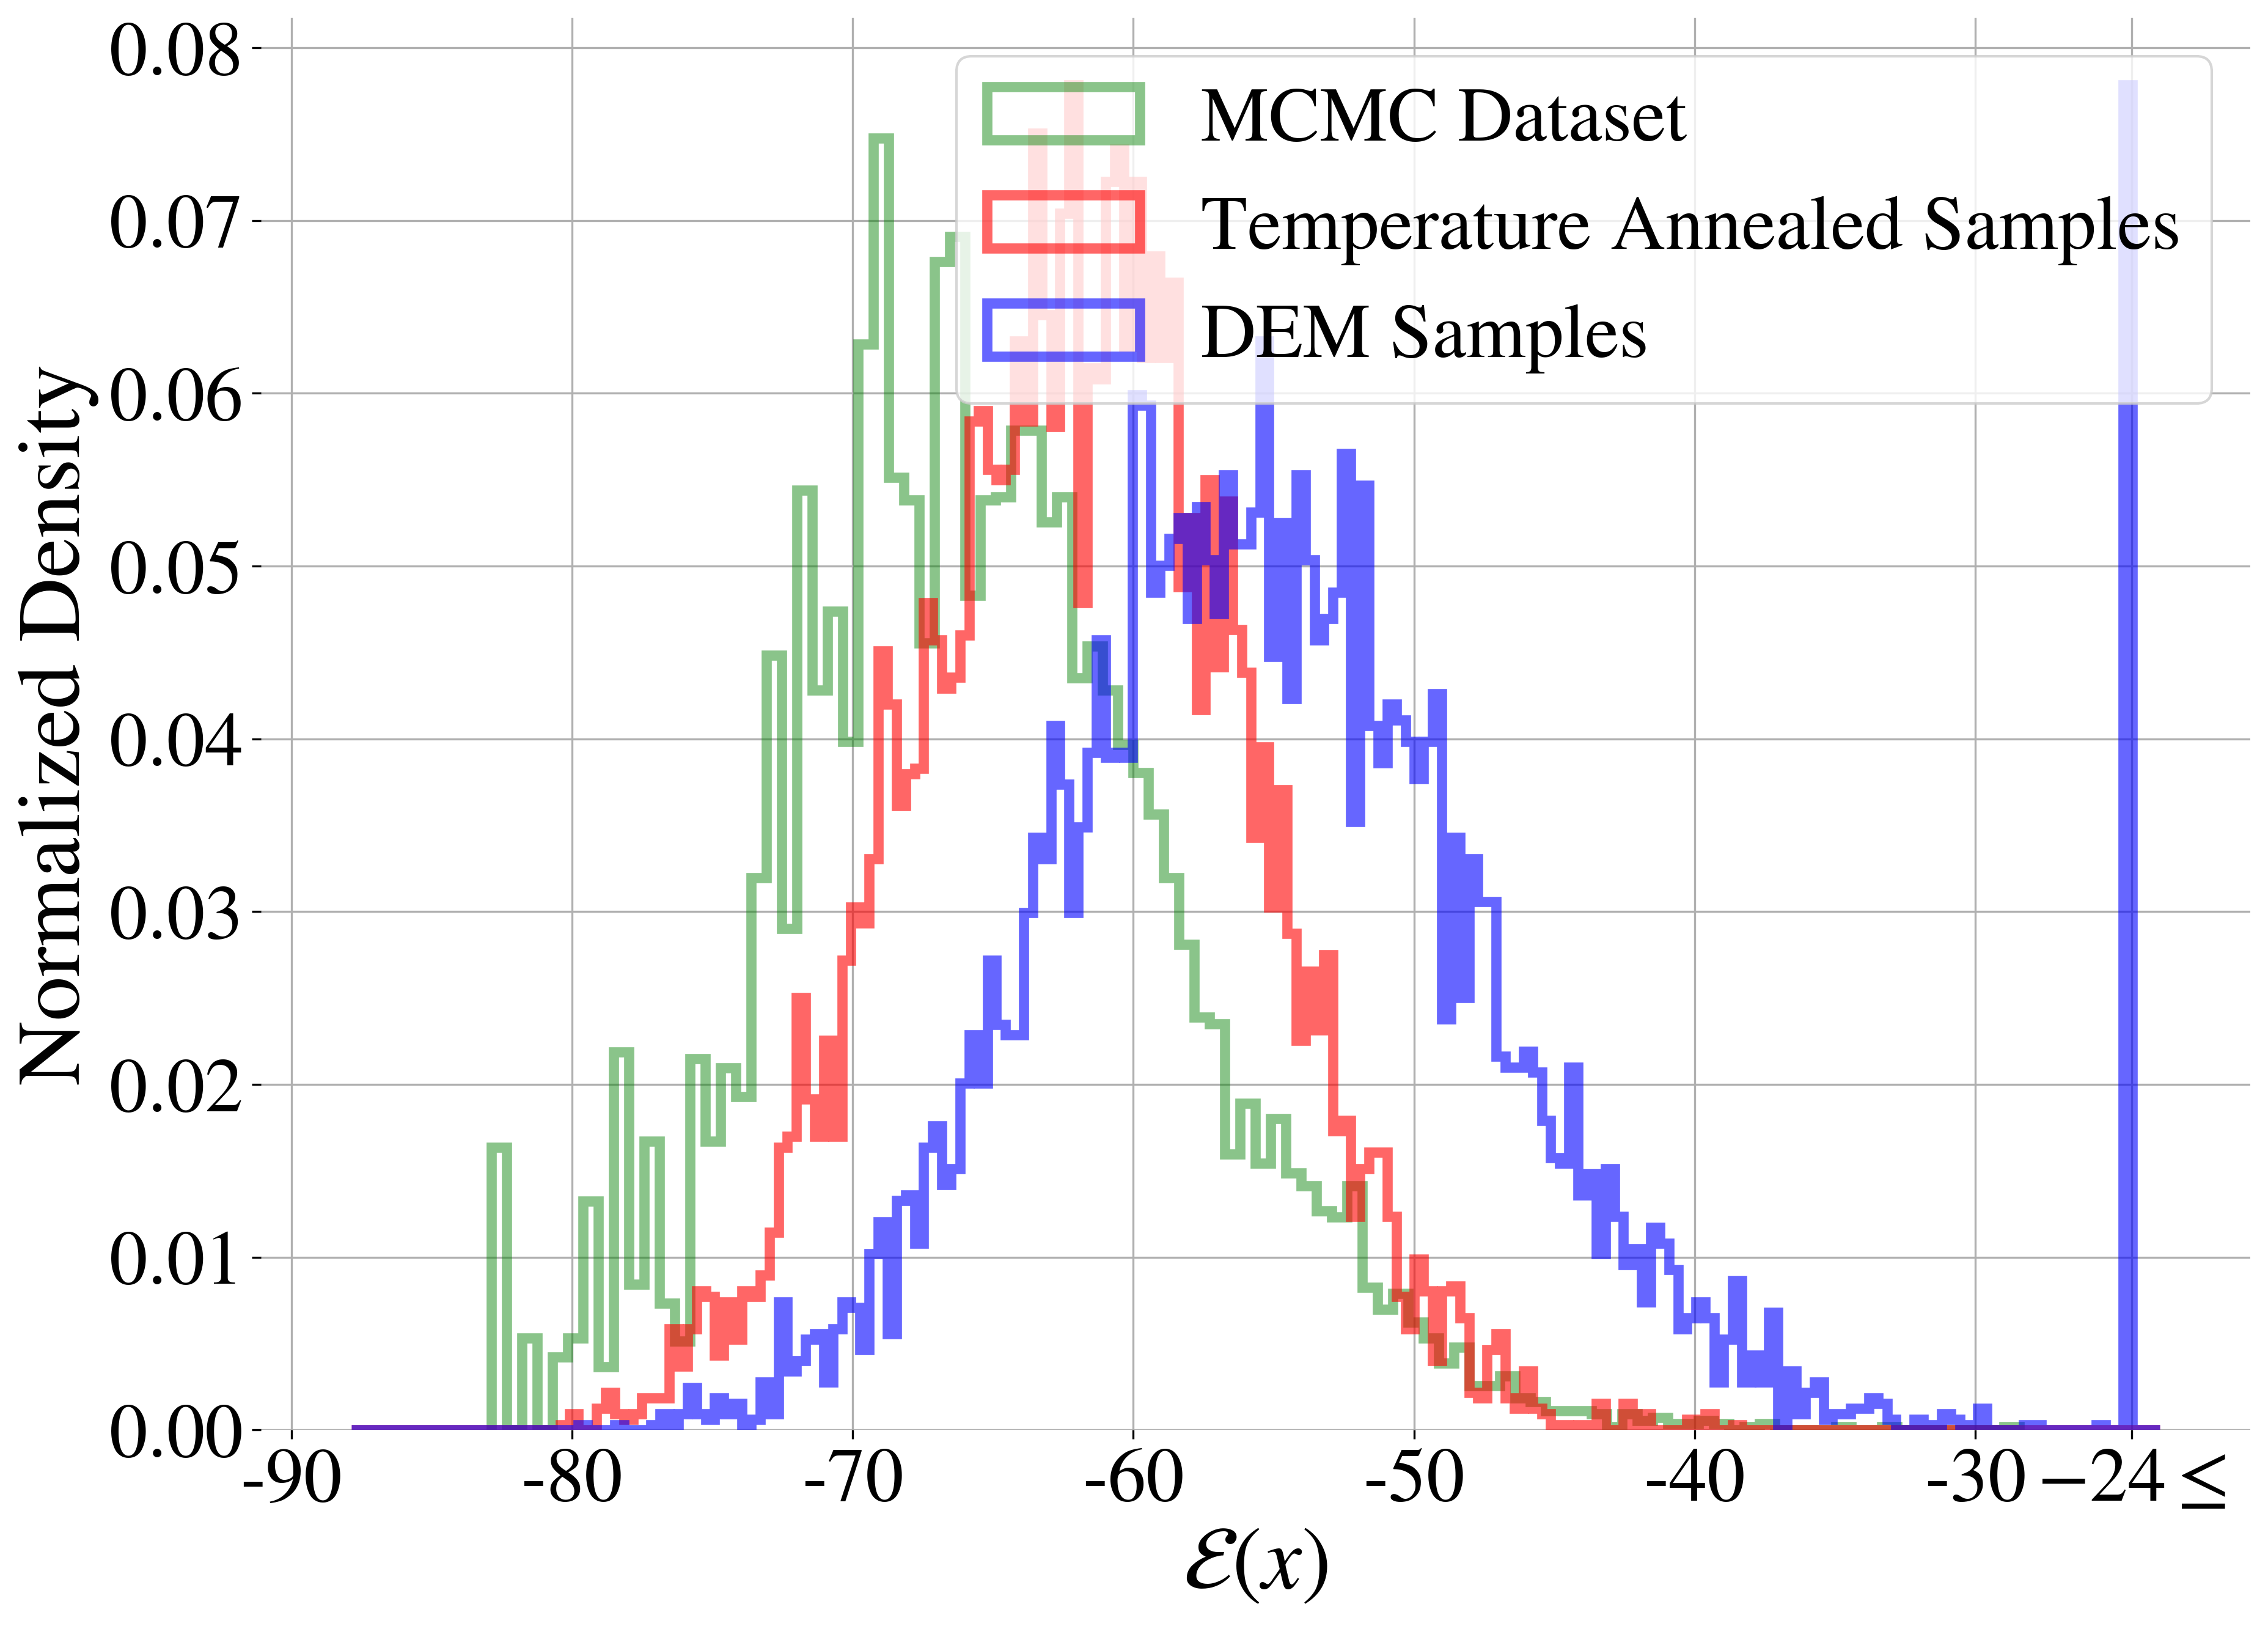

In [19]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
fig.patch.set_facecolor("white")


# bin_edges = np.linspace(-90, -30, 200)
min_bin = (-test_energy).min().item()
max_bin = (-test_energy).max().item()
bin_edges = np.linspace(min_bin - 5, max_bin + 5, 200)


_, bins, _ = ax.hist(
    -test_energy.detach().cpu(),
    bins=100,
    density=True,
    alpha=0.46,
    color="green",
    histtype="step",
    linewidth=4,
    label="MCMC Dataset",
)

ax.hist(
    -annealed_energy.detach().cpu(),
    bins=bin_edges,
    density=True,
    alpha=0.6,
    color="red",
    histtype="step",
    linewidth=4,
    label="Temperature Annealed Samples",
)


ax.hist(
    torch.clip(-dem_energy, max=bin_edges[-1] - 1).detach().cpu(),
    bins=bin_edges,
    density=True,
    alpha=0.6,
    color="blue",
    histtype="step",
    linewidth=4,
    label="DEM Samples",
)


xticks = list(ax.get_xticks())
xticks = xticks[1:-1]

# Add a new xtick (e.g., at x=5) with custom label
new_tick = bin_edges[-1] - 1
custom_label = rf"${new_tick:.0f} \leq $"

# Update xticks and labels
xticks.append(new_tick)
xtick_labels = [str(int(tick)) if tick != new_tick else custom_label for tick in xticks]

# Set new xticks and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=30)

# add xtick at bin_edges[-1] - 1
# plt.xticks([bin_edges[-1] - 1])

plt.xlabel(r"$\mathcal{E}(x)$", fontsize=35)
plt.ylabel("Normalized Density", fontsize=35)
plt.legend(fontsize=30)
plt.yticks(fontsize=30)

plt.grid(True)
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.savefig(f"figures/LJ_samples_temp_{temperature}.png", bbox_inches="tight")
plt.show()

In [35]:
def load_and_sample_data(sde_type, temp, num_samples):
    annealed_samples = []
    for path in annealed_samples_path[sde_type, temp]:
        samples = torch.load(path, weights_only=True)
        annealed_samples.append(samples)

    annealed_samples = torch.cat(annealed_samples)
    return sample_from_tensor(annealed_samples, num_samples)

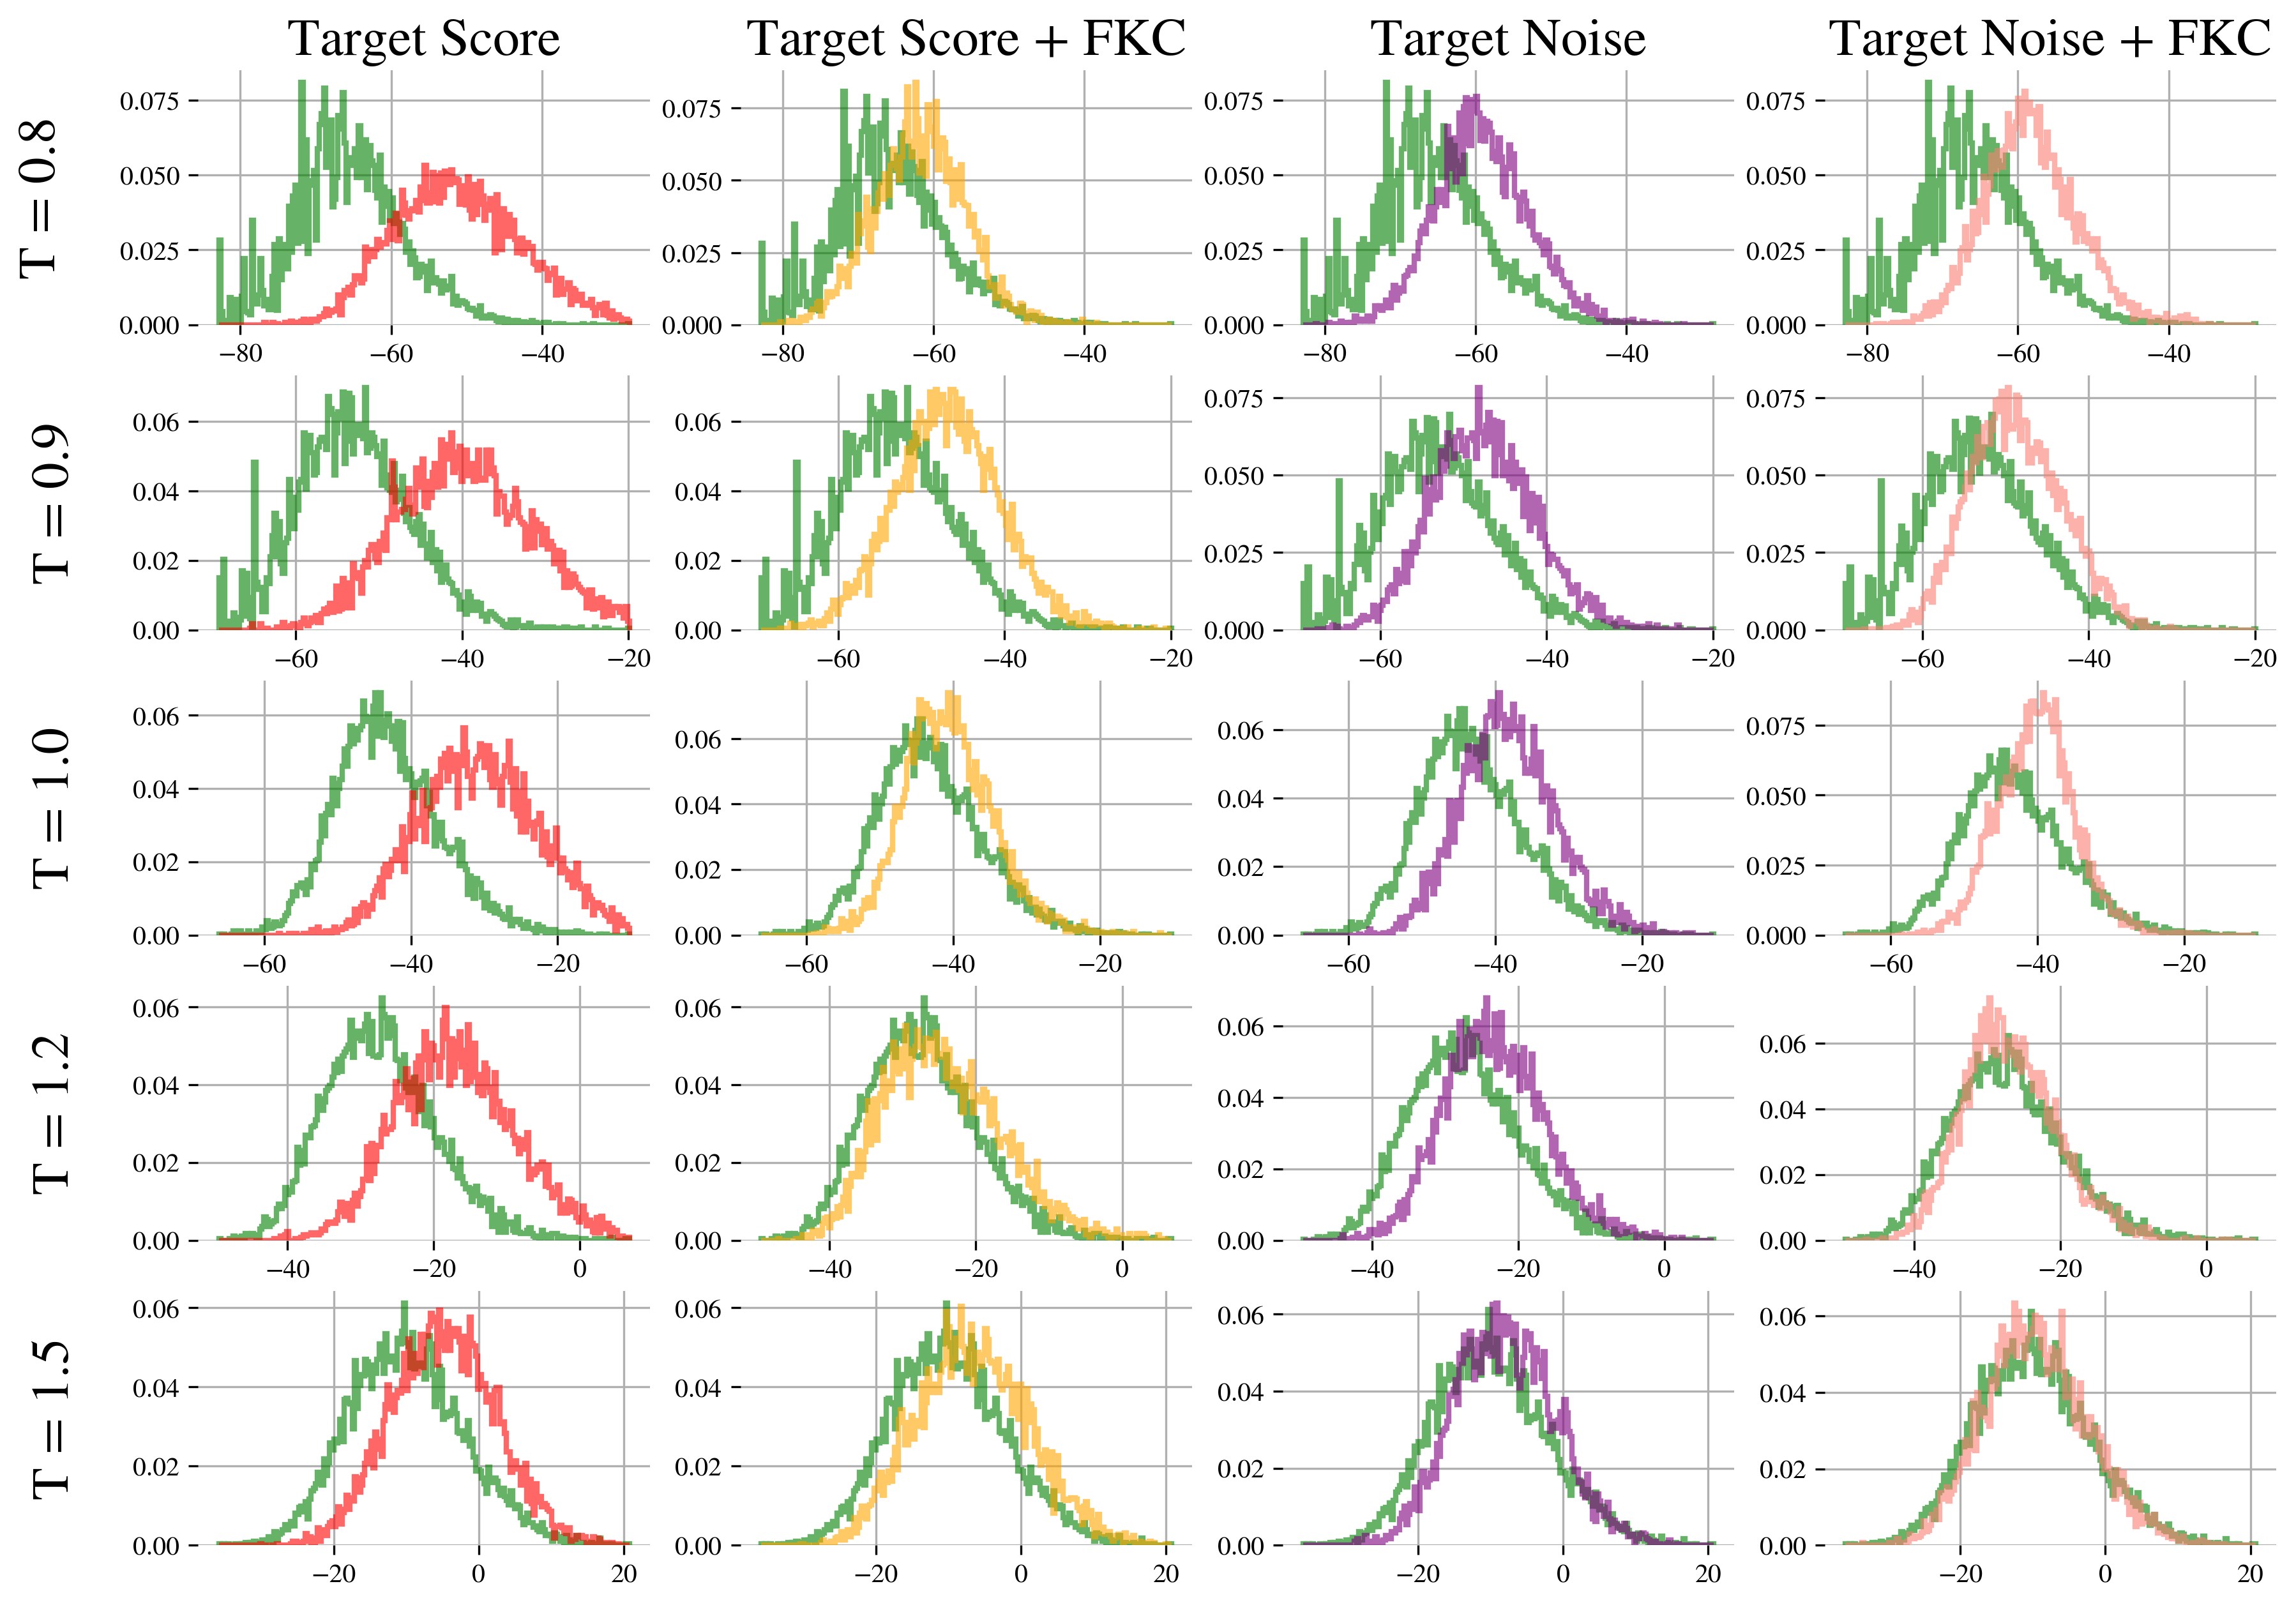

In [61]:
# make a 5 x 4 grid of plots
fig, axs = plt.subplots(5, 4, figsize=(14, 10), dpi=300)
for i, temp in enumerate([0.8, 0.9, 1.0, 1.2, 1.5]):
    target = LennardJonesEnergy(
        dimensionality=dimensionality,
        n_particles=n_particles,
        device=device,
        data_path="../../data/",
        smooth=False,
        temperature=temp,
    )

    test_samples = target.sample_test_set(num_samples)
    test_energy = target(test_samples)

    annealed_samples_ts = load_and_sample_data("ts", temp, num_samples)
    annealed_samples_tn = load_and_sample_data("tn", temp, num_samples)
    annealed_samples_ts_fkc = load_and_sample_data("ts+fkc", temp, num_samples)
    annealed_samples_tn_fkc = load_and_sample_data("tn+fkc", temp, num_samples)

    annealed_energy_ts = target(annealed_samples_ts)
    annealed_energy_tn = target(annealed_samples_tn)
    annealed_energy_ts_fkc = target(annealed_samples_ts_fkc)
    annealed_energy_tn_fkc = target(annealed_samples_tn_fkc)

    colors = ["red", "orange", "purple", "salmon"]
    labels = [
        "Target Score",
        "Target Score + FKC",
        "Target Noise",
        "Target Noise + FKC",
    ]
    s = [
        annealed_energy_ts,
        annealed_energy_ts_fkc,
        annealed_energy_tn,
        annealed_energy_tn_fkc,
    ]
    for j in range(4):
        if i == 0:
            axs[i, j].set_title(labels[j], fontsize=20)

        if j == 0:
            axs[i, j].set_ylabel(f"T = {temp}", fontsize=20, rotation=90, labelpad=20)

        _, bins, _ = axs[i, j].hist(
            -test_energy.detach().cpu(),
            bins=200,
            density=True,
            alpha=0.6,
            color="green",
            histtype="step",
            linewidth=2,
            label="MCMC Dataset",
        )

        axs[i, j].hist(
            -s[j].detach().cpu(),
            bins=bins,
            density=True,
            alpha=0.6,
            color=colors[j],
            histtype="step",
            linewidth=2,
            label=labels[j],
        )

        axs[i, j].spines["top"].set_visible(False)
        axs[i, j].spines["right"].set_visible(False)
        axs[i, j].spines["bottom"].set_visible(False)
        axs[i, j].spines["left"].set_visible(False)
        axs[i, j].xaxis.set_minor_locator(NullLocator())
        axs[i, j].yaxis.set_minor_locator(NullLocator())
        # axis grid true
        axs[i, j].grid(True)


# plt.tight_layout()
plt.savefig("figures/LJ_energies_all_temps.png", bbox_inches="tight")
plt.show()